In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xarray as xr

In [88]:
from ripple_detection.core import gaussian_smooth
smoothing_sigma = 2 # seconds

In [4]:
# Import time-frequency functions
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time, compute_wavelet_transform

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

In [5]:
from ecephys.data import channel_groups, paths
from ecephys.sglx_utils import load_timeseries
from ecephys.signal.timefrequency import compute_spectrogram_welch, get_bandpower, parallel_spectrogram_welch
from ecephys.plot import plot_spectrogram, plot_hypnogram_overlay
from ecephys.scoring import load_visbrain_hypnogram, filter_states
from ecephys.helpers import all_arrays_equal

In [6]:
start_time = 0
end_time = 600
bin_path = Path(paths.lfp_bin["SR"]["Doppio"])

In [7]:
hypno_path = Path(paths.hypnograms["SR"]["Doppio"])
hypno = load_visbrain_hypnogram(hypno_path)

In [8]:
delta_range = (0.5, 4)
theta_range = (5, 10)

In [74]:
def get_spectrogram(sig):
    freqs, spg_times, spg = parallel_spectrogram_welch(sig.values, sig.fs)
    spg_times = spg_times + start_time
    spg = xr.DataArray(spg, dims=("frequency", "time", "channel"), coords={"frequency": freqs, "time": spg_times, "channel": sig.channel.values})
    return spg.median(dim="channel")
    
def _get_bandpower(spg, f_range, chans):
    bandpower = spg.sel(frequency=slice(*f_range)).sum(dim="frequency")
    bandpower.attrs['long_name'] = "{} Hz PSD".format(f_range)
    bandpower.attrs['units'] = 'uV^2/Hz'
    bandpower.attrs['chans'] = chans
    bandpower.attrs['freq_range'] = f_range
    
    return bandpower

## Cortex

In [10]:
cx_chans = channel_groups.superficial_ctx["Doppio"]
cx_sig = load_timeseries(bin_path, cx_chans, start_time=start_time, end_time=end_time, xarray=True)

nChan: 385, nFileSamp: 18000019


In [24]:
cx_spg = get_spectrogram(cx_sig)

In [76]:
cx_theta = _get_bandpower(cx_spg, theta_range, cx_chans)
cx_delta = _get_bandpower(cx_spg, delta_range, cx_chans)

### Plot

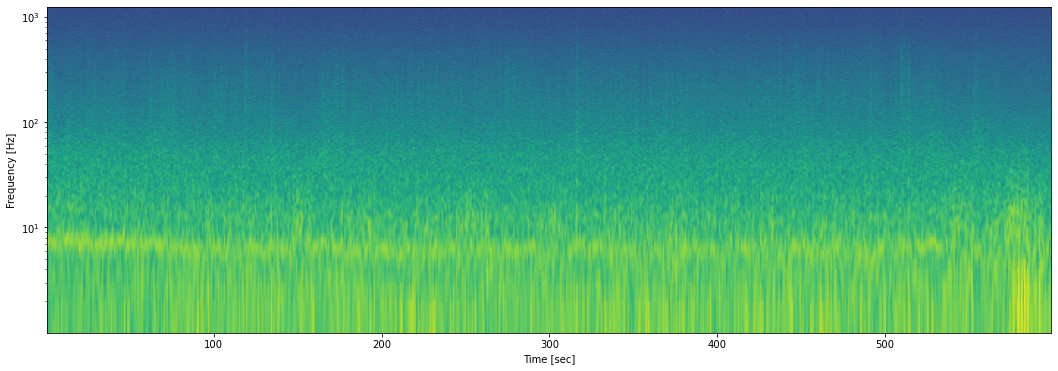

In [27]:
plot_spectrogram(cx_spg.frequency, cx_spg.time, cx_spg, yscale='log')

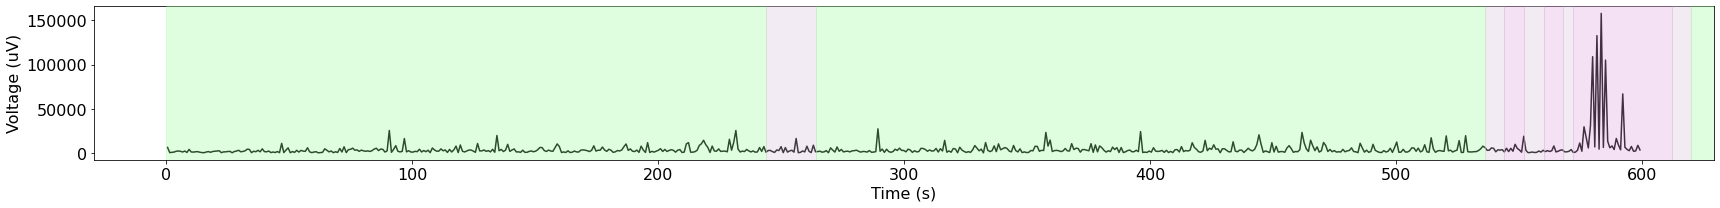

In [77]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

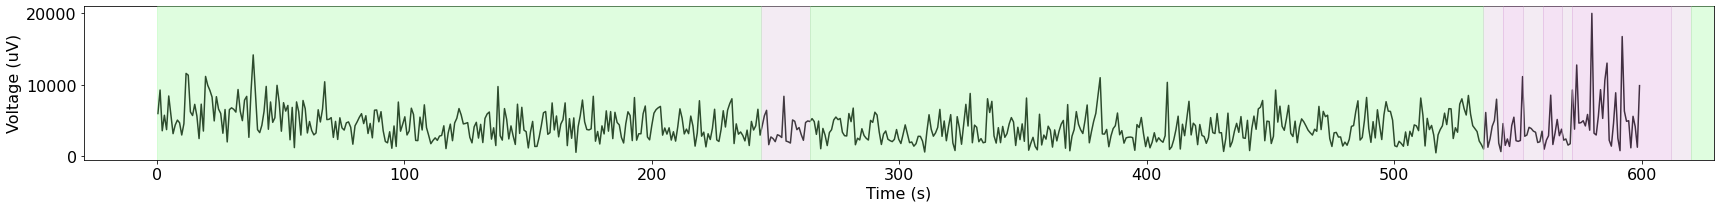

In [78]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_theta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

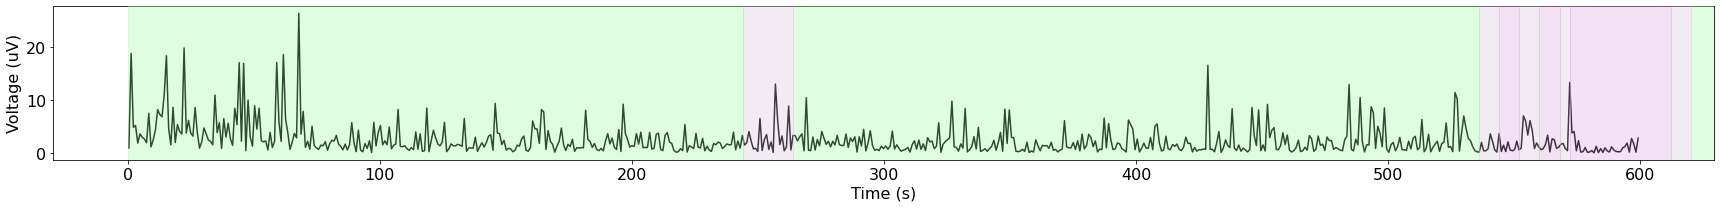

In [79]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_theta.values / cx_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

## Theta

In [84]:
sr_chans = channel_groups.stratum_radiatum_140um_to_200um["Doppio"]
sr_sig = load_timeseries(bin_path, sr_chans, start_time=start_time, end_time=end_time, xarray=True)

nChan: 385, nFileSamp: 18000019


In [85]:
sr_spg = get_spectrogram(sr_sig)

In [86]:
sr_theta = _get_bandpower(sr_spg, theta_range, sr_chans)
sr_delta = _get_bandpower(sr_spg, delta_range, sr_chans)

### Plot

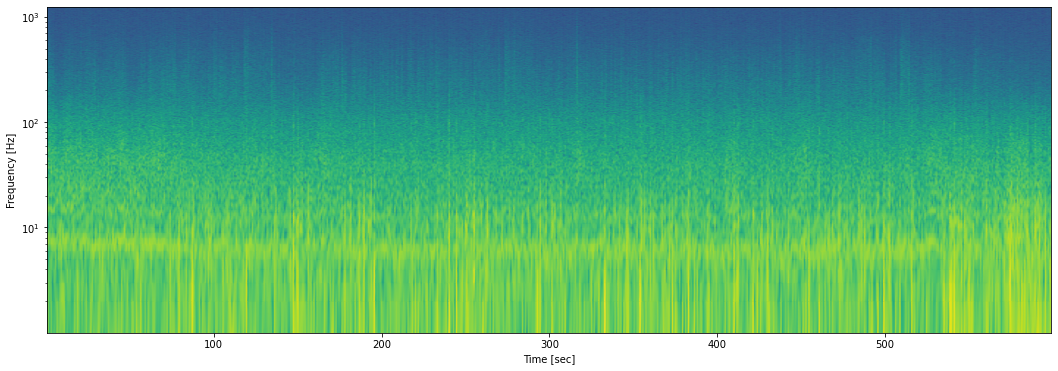

In [87]:
plot_spectrogram(sr_spg.frequency, sr_spg.time, sr_spg, yscale='log')

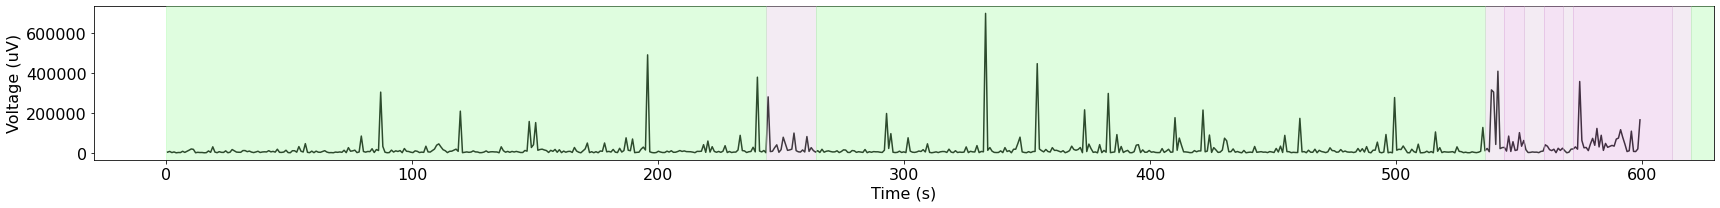

In [89]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(sr_spg.time.values, sr_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

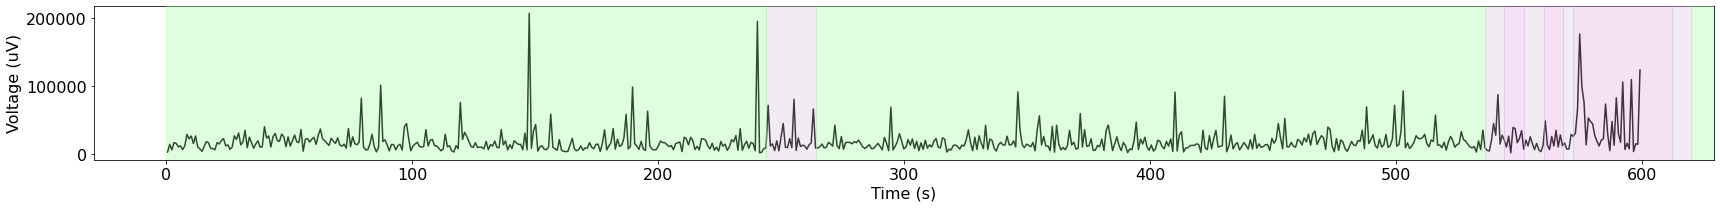

In [90]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(sr_spg.time.values, sr_theta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

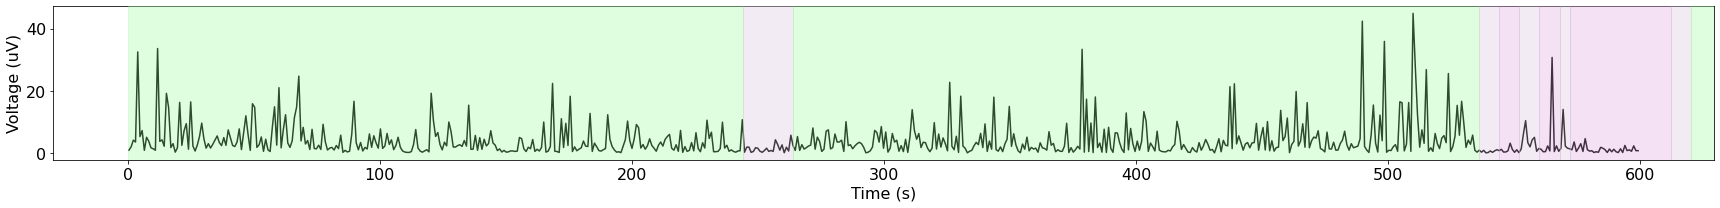

In [91]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(sr_spg.time.values, sr_theta.values / sr_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

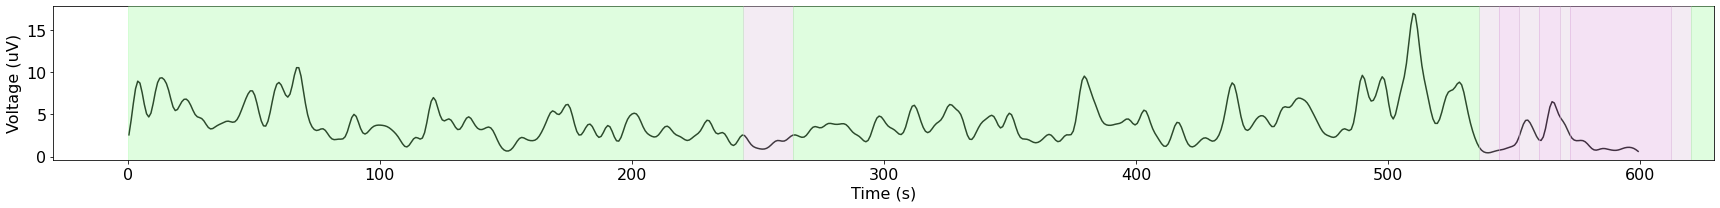

In [92]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(sr_spg.time.values, gaussian_smooth(sr_theta.values / sr_delta.values, smoothing_sigma, 1 / np.diff(sr_spg.time.values).mean()) , ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

## Save

In [132]:
bandpower = xr.Dataset({'mpta_delta': cx_delta, 'mpta_theta': cx_theta, 'sr_delta': sr_delta, 'sr_theta': sr_theta})

In [ ]:
bandpowr.to_netcdf(paths.lfp_bandpower["SR"]["Doppio"])